In [1]:
# Import GoldUtilities
push!(LOAD_PATH, joinpath(@__DIR__, "..", "scripts"))
using GoldUtilities
import GoldUtilities.Loader as loader

In [2]:
# Add the MSSim package
using MSSim
const Opts = MSSim.Optimizers
const SS = MSSim.SegSeq
const SL = MSSim.SymLinear
const Seq = MSSim.Sequence

MSSim.Sequence

In [3]:
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

"module://matplotlib_inline.backend_inline"

In [4]:
params = loader.GoldParams("../system params/072125_goldparams_13ions.json")

GoldUtilities.Loader.GoldParams([2.29306, 2.31375, 2.33556, 2.35784, 2.3805, 2.40237, 2.42394, 2.44446, 2.46356, 2.4808, 2.49555, 2.50966, 2.51611], [0.12582898125060124, 0.1254757153730443, 0.1250569316248486, 0.12461075061627393, 0.12415467122300929, 0.12370104825133979, 0.12325955010900741, 0.12283842408236283, 0.12244532009242795, 0.12208804746084248, 0.12177563418463196, 0.12151470773707744, 0.1213753723354335], [0.002163619698947626 -0.019894333993010195 … -0.019894333993005258 0.0021636196989478743; 0.0071396181636678106 -0.05753283102846898 … 0.05753283102846495 -0.007139618163669534; … ; 0.42615110225953595 0.36754442103650975 … -0.36754442103645346 -0.4261511022594881; 0.2773500981126128 0.2773500981125969 … 0.27735009811265454 0.27735009811265965], Dict("x1" => 0.0, "x4" => 0.00131, "x2" => 0.0124, "qzy" => 0.12, "dy" => 71.0, "qzz" => 0.85, "x3" => 0.0))

In [ ]:
# Construct modes matrtix using system parameters
const modes = Seq.Modes()
const ion1 = 5
const ion2 = 9
for i in 1:13
    push!(modes, 2π * params.radial_modes[i], params.participation_factors[i, ion1] * params.participation_factors[i, ion2] * params.etas[i]^2)
end

In [6]:
# Function to give a balckman amplitude profile
function blackman_start_end(x)
    if -0.5 <= x <= 0.5
        return 1.0
    elseif x < 0
        x = (x + 0.5) * 2
    else
        x = (x - 0.5) * 2
    end
    return 0.42 + 0.5 * cospi(x) + 0.08 * cospi(2 * x)
end

blackman_start_end (generic function with 1 method)

In [7]:
const nseg = 180
const buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
const buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

In [8]:
function _objfunc(vals)
    dis = vals[1]
    disδ = vals[2]
    area = vals[3]
    areaδ = vals[4]
    τ = vals[5]

    return 5 * dis + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);

In [9]:
const nlmodel = Seq.Objective(SL.pmask_full,
                              ((:dis2, 0), (:disδ2, 0), (:area, 0),
                               (:areaδ, 0), (:τ, 0)),
                              objfunc, modes, buf_opt,
                              freq=Seq.FreqSpec(true, sym=false),
                              amp=Seq.AmpSpec(cb=blackman_start_end));

In [10]:
const nargs = Seq.nparams(nlmodel)
const tracker = Opts.NLVarTracker(nargs)
Opts.set_bound!(tracker, nlmodel.param.τ, 0.1, 4)
Opts.set_bound!(tracker, nlmodel.param.Ωs[1], 0.1, 0.2)
for ω in nlmodel.param.ωs
    Opts.set_bound!(tracker, ω, 2π * 2.29, 2π * 2.50)
end

In [11]:
# const opt = NLopt.Opt(:LD_SLSQP, nargs)
const opt = NLopt.Opt(:LD_LBFGS, nargs)
# NLopt.xtol_rel!(opt, 1e-5)
# NLopt.ftol_rel!(opt, 1e-5)
NLopt.min_objective!(opt, nlmodel)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
NLopt.maxtime!(opt, 10)

In [12]:
best_obj = 100.0
best_params = nothing
@time for i in 1:50
    global best_obj, best_params
    obj, params, ret = @time NLopt.optimize(opt, Opts.init_vars!(tracker))
    if getfield(NLopt, ret) < 0
        continue
    end
    if obj < best_obj
        best_obj = obj
        area = nlmodel(Val((:area, 0)), params)
        best_status = (
            obj = obj,
            dis = nlmodel(Val((:dis2, 0)), params),
            disδ = nlmodel(Val((:disδ2, 0)), params),
            area = area,
            areaε = abs(area) - π / 2,
            areaδ = nlmodel(Val((:areaδ, 0)), params),
            total_t = nlmodel(Val((:τ, 0)), params),
            Ωmax = params[nlmodel.param.Ωs[1]],
        )
        println(best_status)
        best_params = params
    end
end

 10.001920 seconds (9.33 M allocations: 465.374 MiB, 1.17% gc time, 63.45% compilation time)
  7.706779 seconds (148.60 k allocations: 7.655 MiB)
  4.810164 seconds (86.05 k allocations: 4.434 MiB)
 10.001129 seconds (206.29 k allocations: 10.626 MiB)
  0.079535 seconds (1.71 k allocations: 92.828 KiB)
  0.075445 seconds (1.64 k allocations: 89.453 KiB)
  0.082642 seconds (1.80 k allocations: 97.891 KiB)
  4.390494 seconds (84.85 k allocations: 4.372 MiB)
 10.000114 seconds (208.60 k allocations: 10.745 MiB, 0.21% gc time)
(obj = 15.572451619775746, dis = 0.24536095924498127, disδ = 0.5081840246182744, area = 1.19210695860728, areaε = -0.37868936818761645, areaδ = 11.070099568641043, total_t = 607.7720494526833, Ωmax = 0.2)
  4.075528 seconds (73.00 k allocations: 3.762 MiB)
 10.000238 seconds (183.86 k allocations: 9.471 MiB)
 10.000341 seconds (210.99 k allocations: 10.868 MiB)
 10.000193 seconds (197.49 k allocations: 10.173 MiB, 0.12% gc time)
 10.001484 seconds (197.06 k allocatio

In [13]:
opt_raw_params = Seq.RawParams(nlmodel, best_params)
println(opt_raw_params)

MSSim.Sequence.RawParams([3.788391816816655, -2.7755575615628915e-18, 2.3198253541932113e-5, 0.0, 15.615408952783264, 3.788391816816655, 8.788407388269082e-5, 7.008150154766093e-5, 59.15728749296965, 15.351570186079705, 3.788391816816655, 0.0003533802608560732, 0.00011841092731055327, 117.31505036120055, 14.466552853810425, 3.788391816816655, 0.000801967248901045, 0.00016910412828106028, 172.1200208101216, 14.461129383733192, 3.788391816816655, 0.0014425999446709276, 0.00022300994920630997, 226.90444502938328, 14.725149352408156, 3.788391816816655, 0.00228744901131281, 0.0002808830178138675, 282.6890803374494, 14.855104319179638, 3.788391816816655, 0.0033515439374816325, 0.0003433602686985657, 338.9660359781873, 14.388494353441253, 3.788391816816655, 0.004652327169639247, 0.0004109399551632347, 393.47529024307676, 14.437690624918437, 3.788391816816655, 0.006209128732982648, 0.00048396359937826557, 448.1709192602483, 15.450346146651379, 3.788391816816655, 0.008042572472504403, 0.0005626

In [14]:
kern = SL.Kernel(buf_plot, Val(SL.pmask_full));

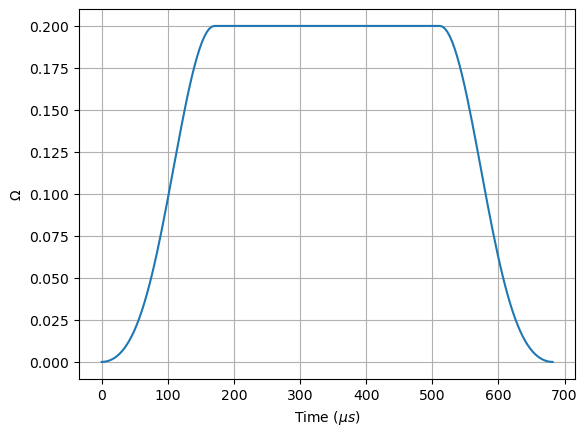

In [15]:
clf()
plot(Seq.get_Ωs(opt_raw_params)...)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\Omega$")
grid()
display(gcf())

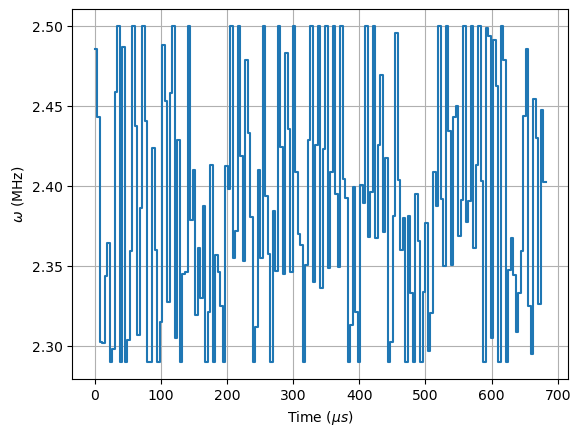

In [16]:
clf()
ts, ωs = Seq.get_ωs(opt_raw_params)
plot(ts, ωs ./ 2π)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\omega$ (MHz)")
grid()
display(gcf())

In [17]:
println("Total displacement:")
println(Seq.total_dis(kern, opt_raw_params, modes))
println("cumulative displacement:")
println(Seq.total_cumdis(kern, opt_raw_params, modes))
println("Gradient of displacement w.r.t. detuning (disδ)")
println(Seq.total_disδ(kern, opt_raw_params, modes))
println("Enclosed area (area)")
println(Seq.total_area(kern, opt_raw_params, modes))
println("Gradient of enclosed area w.r.t. detuning (areaδ)")
println(Seq.total_areaδ(kern, opt_raw_params, modes))

Total displacement:
0.015445677697280077
cumulative displacement:
7211.170602753889
Gradient of displacement w.r.t. detuning (disδ)
0.03110133560074679
Enclosed area (area)
1.4498147182347074
Gradient of enclosed area w.r.t. detuning (areaδ)
1.237509885425437


In [18]:
plot_δs = range(-1, 1, 10001); # kHz

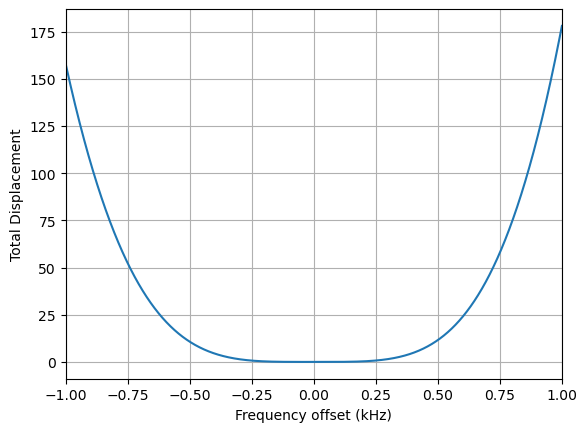

In [19]:
clf()
plot(plot_δs, [Seq.total_dis(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) for δ in plot_δs])
xlim([-1, 1])
# ylim([0, 100])
xlabel("Frequency offset (kHz)")
ylabel("Total Displacement")
grid()
display(gcf())

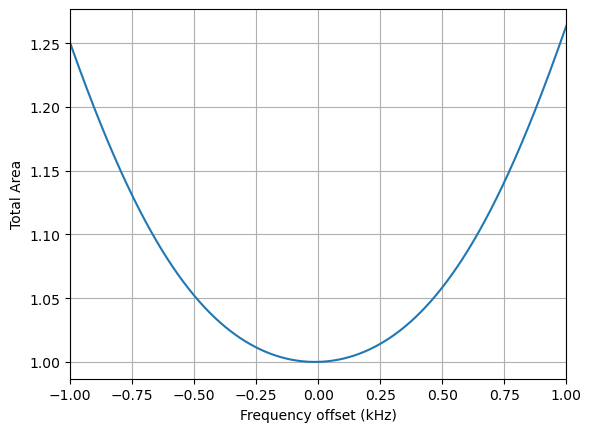

In [20]:
clf()
area0 = Seq.total_area(kern, opt_raw_params, modes)
plot(plot_δs, [Seq.total_area(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) / area0 for δ in plot_δs])
xlim([-1, 1])
xlabel("Frequency offset (kHz)")
ylabel("Total Area")
grid()
display(gcf())